In [1]:
!pip install pennylane pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.6 MB/s eta 0:00:00


In [64]:
import pandas as pd
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
url = "https://raw.githubusercontent.com/ilayd-a/SFE-Finder/refs/heads/main/qml_training-validation-data.csv"
data = pd.read_csv(url)

# Select features and target
X = data[['el_neg', 'B/GPa', 'Volume/A^3']].values
y = data['SFE/mJm^-3'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [81]:
import pennylane as qml

n_qubits = X_train_scaled.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode the classical input data into quantum states
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply parameterized quantum gates
    for i in range(n_qubits):
        qml.RX(weights[i], wires=i)
        qml.RY(weights[i+n_qubits], wires=i)
        qml.RZ(weights[i+2*n_qubits], wires=i)

    # Measure the expectation value of Z on all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [86]:
def hybrid_model(inputs, weights):
    quantum_outputs = quantum_circuit(inputs, weights)
    return np.clip(np.sum(quantum_outputs), -1e3, 1e3)

def cost(weights, X, y, lambda_reg=0.01):
    predictions = np.array([hybrid_model(x, weights) for x in X])
    mse = np.mean((predictions - y) ** 2)
    l2_reg = lambda_reg * np.sum(weights ** 2)
    return mse + l2_reg

In [87]:
from pennylane import numpy as np

np.random.seed(42)
n_params = 3 * n_qubits  # 3 parameters per qubit
init_weights = np.random.uniform(low=-0.1, high=0.1, size=n_params)

opt = qml.AdamOptimizer(stepsize=0.01)
steps = 500  # Increase number of steps

for i in range(steps):
    weights = opt.step(lambda w: cost(w, X_train_scaled, y_train_scaled), weights)
    if (i+1) % 50 == 0:
        # Reduce learning rate
        opt.stepsize *= 0.9
        print(f"Step {i+1}, Cost: {cost(weights, X_train_scaled, y_train_scaled):.4f}")

Step 50, Cost: 0.1264
Step 100, Cost: 0.1218
Step 150, Cost: 0.1201
Step 200, Cost: 0.1196
Step 250, Cost: 0.1195
Step 300, Cost: 0.1195
Step 350, Cost: 0.1195
Step 400, Cost: 0.1195
Step 450, Cost: 0.1195
Step 500, Cost: 0.1195


In [88]:
train_predictions = np.array([hybrid_model(x, weights) for x in X_train_scaled])
train_mse = np.mean((train_predictions - y_train) ** 2)
print(f"Train MSE: {train_mse:.4f}")

test_predictions = np.array([hybrid_model(x, weights) for x in X_test_scaled])
test_mse = np.mean((test_predictions - y_test) ** 2)
print(f"Test MSE: {test_mse:.4f}")

Train MSE: 463.3642
Test MSE: 496.5442


In [89]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_scaled = np.array([hybrid_model(x, weights) for x in X_test_scaled])
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Calculate accuracy as 1 - (MAE / range of target values)
y_range = np.max(y) - np.min(y)
accuracy = 1 - (mae / y_range)
print(f"Accuracy: {accuracy:.4f}")

Mean Absolute Error: 1.5390
R-squared Score: 0.9811
Accuracy: 0.9618


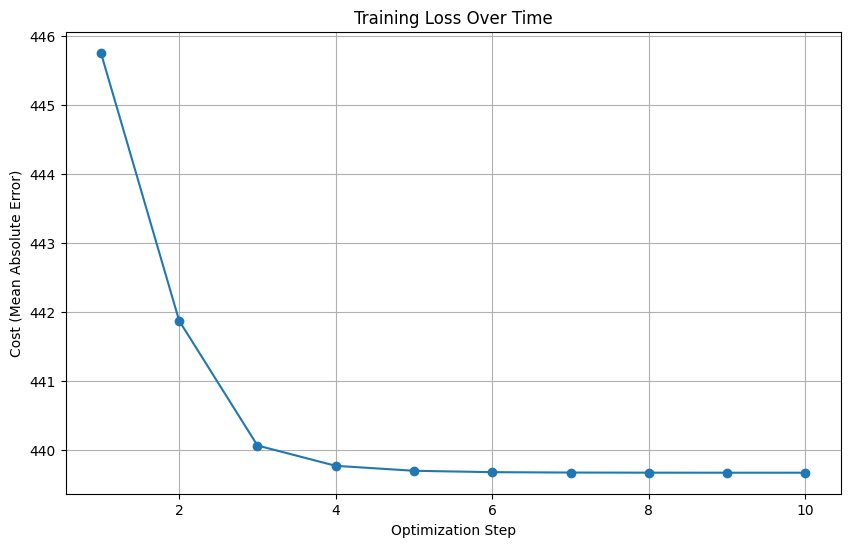

In [90]:
import matplotlib.pyplot as plt

def plot_training_loss(costs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(costs) + 1), costs, marker='o')
    plt.title('Training Loss Over Time')
    plt.xlabel('Optimization Step')
    plt.ylabel('Cost (Mean Absolute Error)')
    plt.grid(True)
    plt.show()

# Use this function after training
plot_training_loss(costs)  # Assuming 'costs' is a list of cost values recorded during training

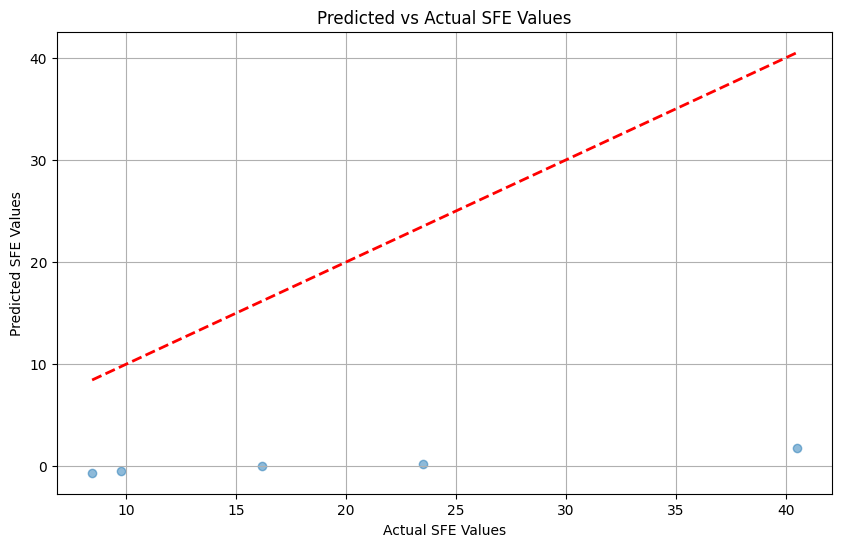

In [91]:
def plot_predictions_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual SFE Values')
    plt.ylabel('Predicted SFE Values')
    plt.title('Predicted vs Actual SFE Values')
    plt.grid(True)
    plt.show()

# Use this function after making predictions
y_pred = np.array([hybrid_model(x, weights) for x in X_test_scaled])
plot_predictions_vs_actual(y_test, y_pred)

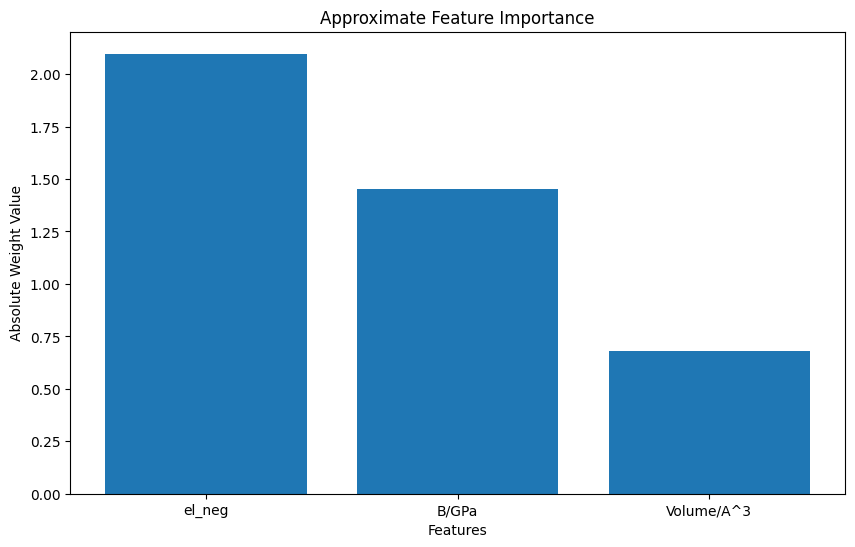

In [92]:
def plot_feature_importance(X, weights):
    n_features = X.shape[1]
    importance = np.abs(weights[:n_features])
    feature_names = ['el_neg', 'B/GPa', 'Volume/A^3']

    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importance)
    plt.title('Approximate Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Absolute Weight Value')
    plt.show()

# Use this function after training
plot_feature_importance(X_train, weights)